# Implementing a Discrete-time Quantum Walk using Classiq

## Problem Statement

The problem statement as given in Assignment 6.12 of the Classiq module in the Womanium Quantum+AI Program, 2024 is:

"Design the quantum walk operator for the case of a line with 16 nodes"

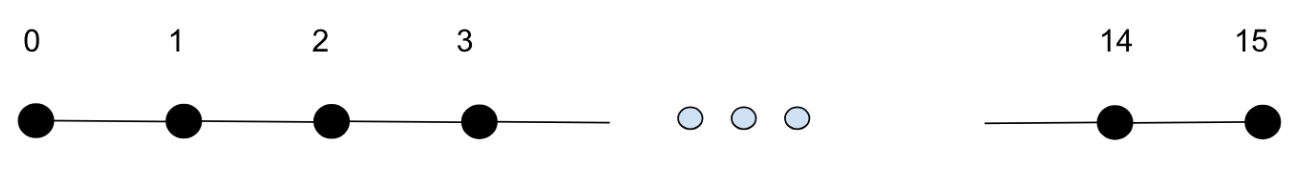

The Classiq Bootcamp 4 covered the explanation and implementation of the discrete-time quantum walk algorithm for a circular graph with 4 nodes.

This notebook provides an explanation of the quantum walk algorithm as well as its implementation for a graph consisting of a line of 16 nodes.

## Explanation of Discrete-time Quantum Walk Algorithm

### 1) Data Encoding

The discrete-time quantum walk algorithm is used for executing a random walk in a graph. Every step in the walk is the equivalent of taking a step by moving from one vertex of a graph to another, through some edge. We assume that the nodes on the graph are represented using qubits encoded as numbers (we will use QNums in Classiq).

### 2) Evolution of the Quantum State

The $W$ Operator (or walk operator) represents one step of a random walk and is executed several times, iteratively to complete a random walk across a graph. This $W$ operator can be logically divided into two operators applied in succession, namely the $C$ and $S$ operations.

#### 2.1) The $C$ Operator
The $C$ operator, or "Coin Operator" is used to determine the available next steps based on which nodes are adjacent to the current node. It takes the current node in the walk and produces an equal superposition state of nodes which are adjacent to the current node, and consequently can be potential visited nodes in the next step.

In essence, the C operator distributes the probabilities of what nodes can be visited next by:
* Keeping probablities of visiting non-adjacent nodes in the next immediate step of the random walk = 0
* Yielding an equal superposition state of adjacent nodes to be visited in the subsequent step of the random walk

#### 2.2) The $S$ Operator
The $S$ operator, or "Shift Operator" is used to make a move in the discrete-time quantum walk.
For a given current vertex and each possible adjacent node that can be visited in the next step of the walk, the states representing the pairs of nodes of the edge are swapped. This represents a shift or a movement in the graph, contributing to the random walk. 

### 3) Measurement and Post-Processing of Results

State measurement and post-processing of results is not applicable to this example, however is an important part of the process for many quantum algorithms. In this example, the only output that will be analyzed is the adjacent node state probability vectors for each source node, to verify correctness of the implementation of $C$ and $S$ operators.

## Implementation of Discrete-time Quantum Walk for 16-Node Line Graph (using Classiq)

### $W$ Operator = $C$ Operator + $S$ Operator

#### 1) C Operator

In [6]:
from classiq import *
size = 4 #4 qubits required to count 0-15 (i.e. 16) vertices as 2^4 = 16

#Prepare |-> state from |0>:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)

#Oracle for phase kickback of non-zero values of x:
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0) #All non-zero values get a phase kickback but not |0>

#Apply the diffusion operator using the diffuzer oracle defined above:
@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

#Creating superposition of probable next steps in the quantum walk, given current node, "i" (C operator for node i):
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    probabilities = [0] * 16 #There are 16 nodes
    
    # 1) End node probabilities: {specific to this graph}
    if i == 0:
        probabilities[1] = 1.0
    elif i == 15:
        probabilities[14] = 1.0
    
    # 2) Middle node probabilities: {specific to this graph}
    else:
        probabilities[i-1] = probabilities[i+1] = 0.5
    print(f'State={i}, probability vec ={probabilities}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=probabilities, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

#Applying C operator to all nodes of the graph:
@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size): #No. of nodes = 16 = 2^4
      C_iteration(i,vertices,adjacent_vertices)

Important points:
* A size of 4 qubits was chosen. Why? As discussed earlier, the data encoding step of the discrete-time quantum random walk algoritm involves interpreting the qubits as numbered indices of nodes in the graph. It is mentioned that there are 16 nodes in this graph, thus $log_{2}(16) = 4$ qubits are required to encode all the vertices/nodes of the graph.
* A diffusion operator is used to give a phase kickback to all non-zero states in the graph, based on the mathematical formulation of the C operator.
* For a given node, $i$, the C operator describes the probability distribution of immediately makeable moves. Hence, in a line, at the end points of $i=0$ and $i=15$, the only possible move with 1.0 probability are to node 1 and node 14 respectively.
* Similarly, at any middle point ($i=1$ to $i=14$), there are only 2 possible moves. One to the immediately preceding and one to the immediately following node, each having a probability of 0.5
* The use of the within-apply construct of classiq is used where, state preparations are done prior to a computational step, followed by applying its inverse automatically
* The C operator is applied on every node of the graph

#### 2) S Operator

In [13]:
#Oracle implementation to detect whether or not 2 vertices are adjacent or not (i.e. connected by an edge or not):
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  #Auxiliary qubit, res, is marked as |0> or |1> if there does/ does not exist any edge between them respectively:
  #If magnitude of difference is 1, there is an edge {Specific to this graph}
  res |= ((vertices - adjacent_vertices == 1) | (vertices - adjacent_vertices == -1))

#Bitwise swap of node states:
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  
#Performs a bitwise swap if an edge exists between nodes (when auxiliary qubit res == 1):
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

Important points:
* The edge oracle is used to mark an auxiliary qubit with whether or not there exist edges in between pairs of vertices. In the case of this line graph, only numerically adjacent nodes (i.e. nodes with magnitude of difference between indices = 1) have edges between them.
* Bitwise swap swaps the states of 2 QArrays bit-by-bit
* The S operator performs the bitwise swap operation only when the 2 nodes are adjacent (i.e. marked by the edge oracle, through the auxiliary qubit res being |1>)

### Main Function

In [14]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
  #Allocate and initialize the required number of qubits:
  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  #Apply the W operator (= C operator + S operator):
  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

Important points:
* 4 qubits are allocated for the vertices and adjacent vertices to fit the state space (discussed earlier)
* Hadamard transform is used to put the initial state as a superposition of all possible starting states for the quantum random walk. This enables us to take advantage of quantum parelellism when applying the walk operator.
* The W operator is applied once, denoted a single step of the random walk, by first applying the coin operator, followed by the shift operator

## Execution and Analysis

In [15]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, probability vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, probability vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, probability vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, probability vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, probability vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, probability vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, probability vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, probability vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, probability vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, probability vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, probability vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, probability vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, probability vec =[0, 0, 0, 0, 0, 0, 0, 0, 

On first inspection, it is observed that the probability vectors yielded for each state is correct:
* End vertex, state 0 has a guaranteed transition to state 1
* End vertex, state 15 has a guaranteed transition to state 14
* The remaining middle vertices, each have a equally probably transition either to the previous or successive node in the line

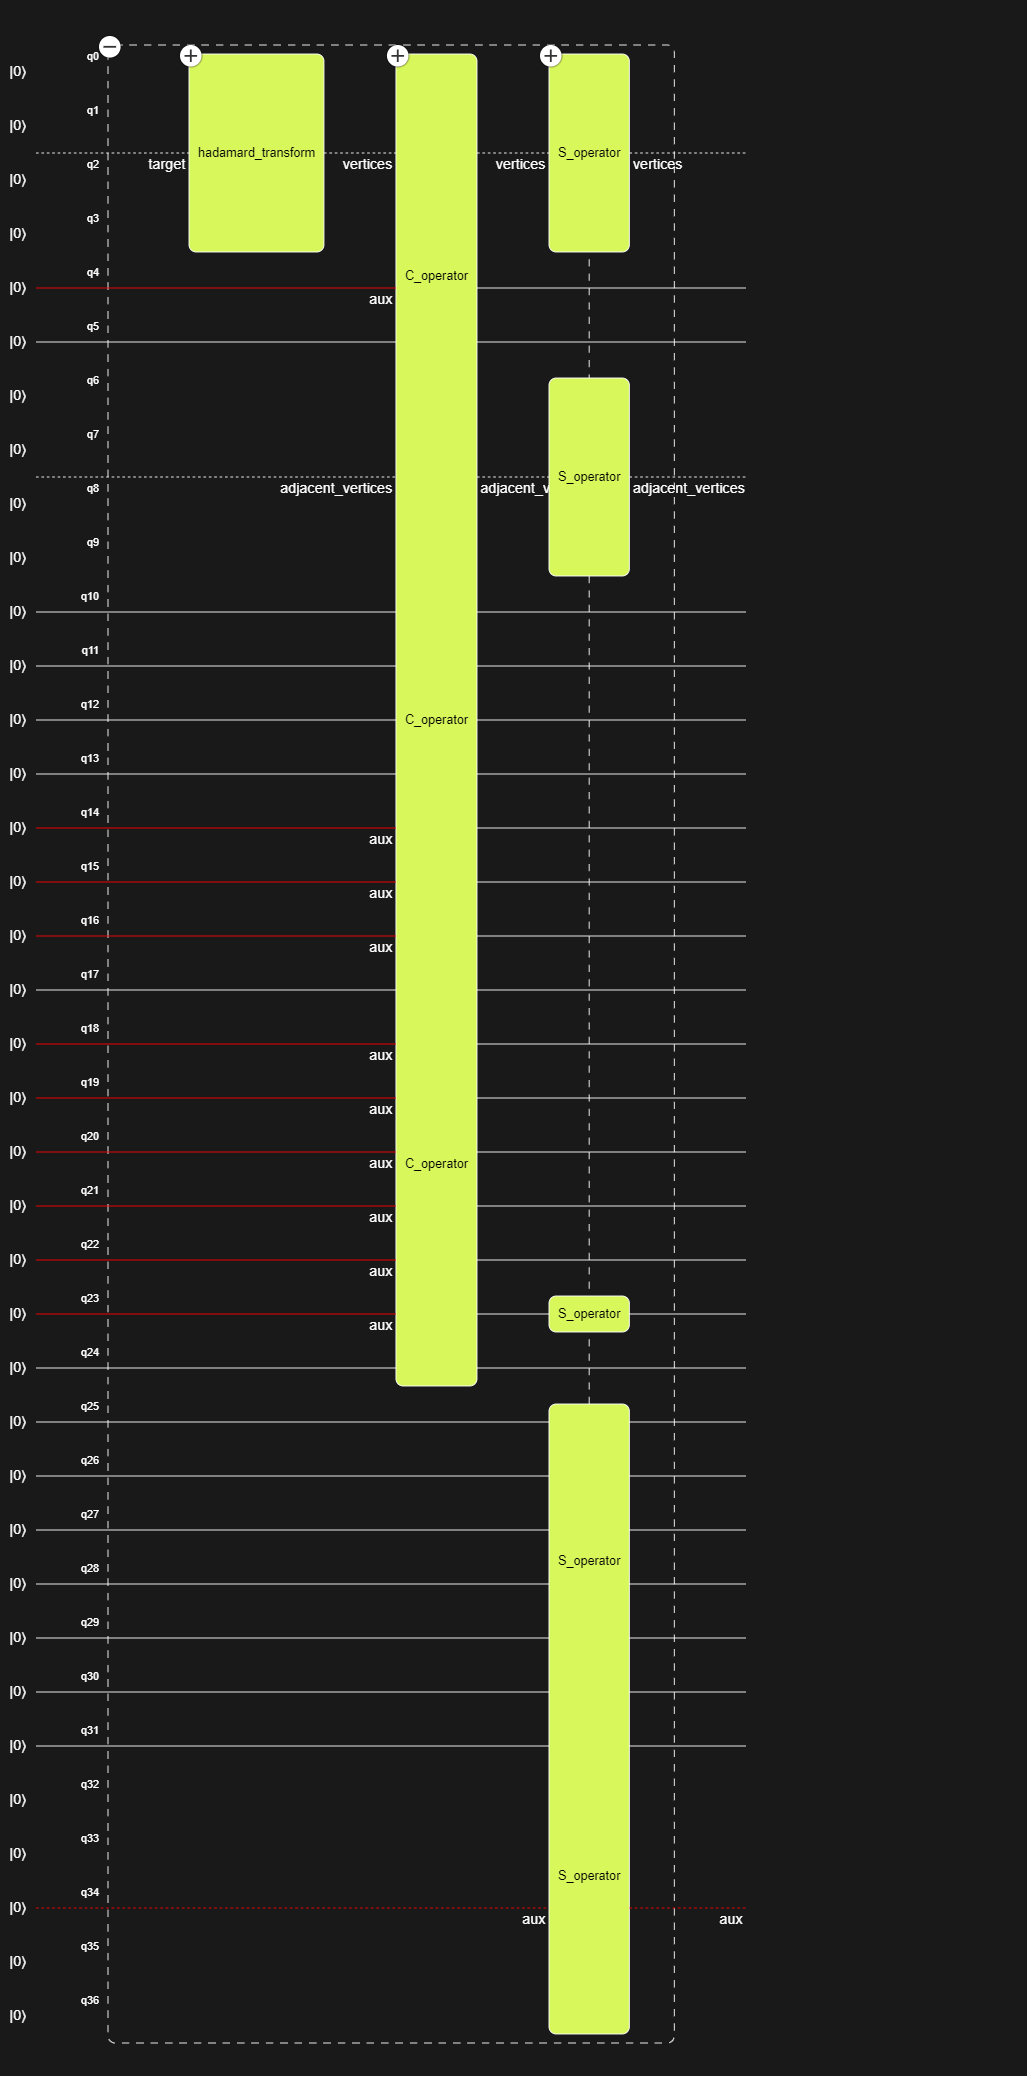
Fig. 1: High Level Implementation

From the high-level implementation shown in Fig. 1, it can be seen that the circuit:
* Initializes the states using a hadamard transform
* Applies the C_operator
* Applies the S_operator

Hence, the circuit performs one step of a discrete-time quantum random walk.

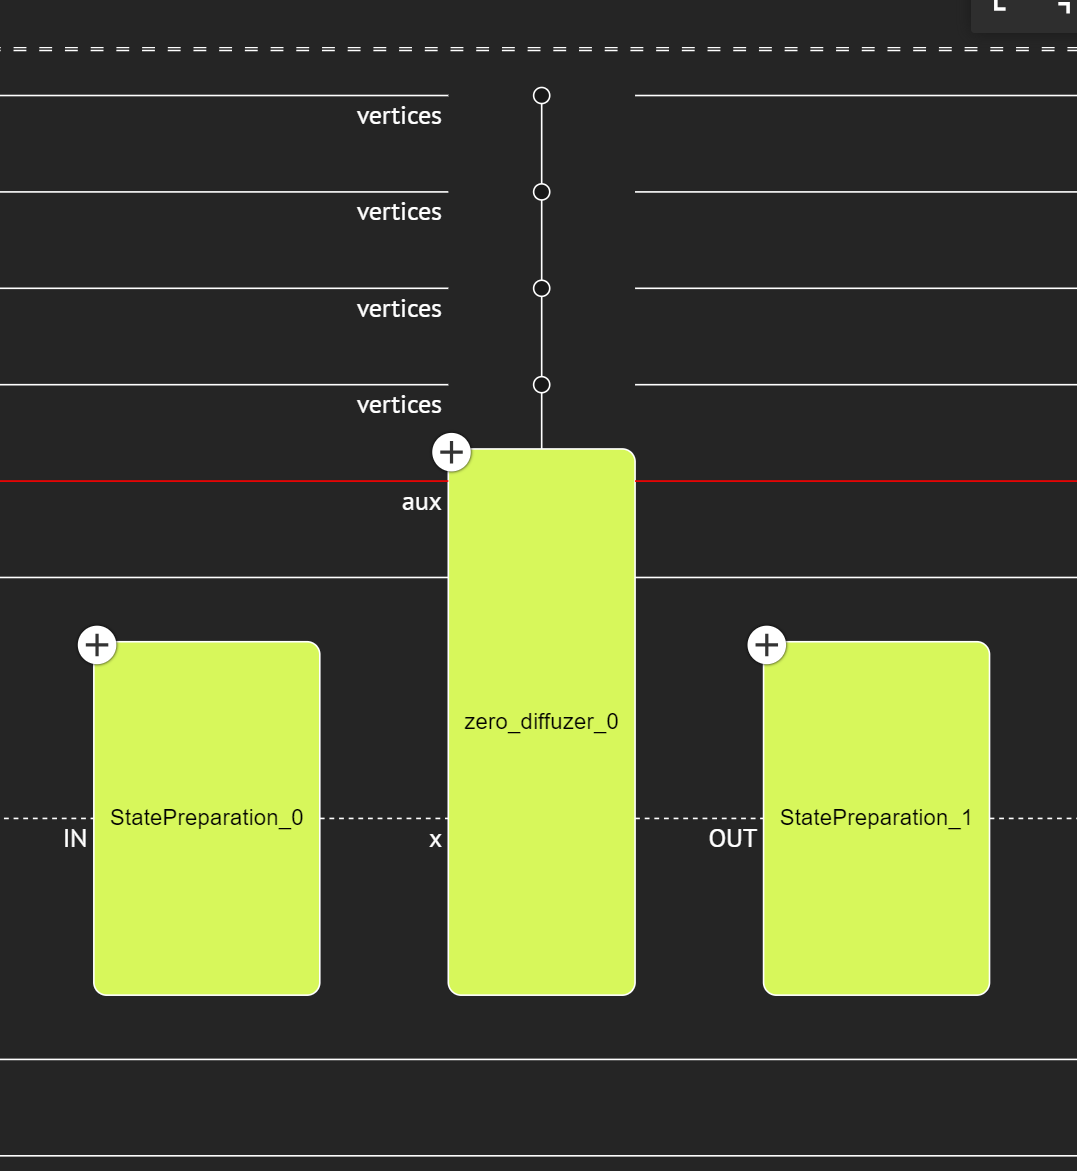
Fig. 2: C Operator Building Block

Fig. 2 shows one of the building blocks for the C Operator. It consists of the:
* Inplace state preparation
* Zero diffuser (which marks non-zero states with a phase kickback)
* Inverse operation of state prepared (hence, within-apply construct in Classiq is used for implementation)

There are 16 such building blocks of the C Operator, one for each node in the graph.

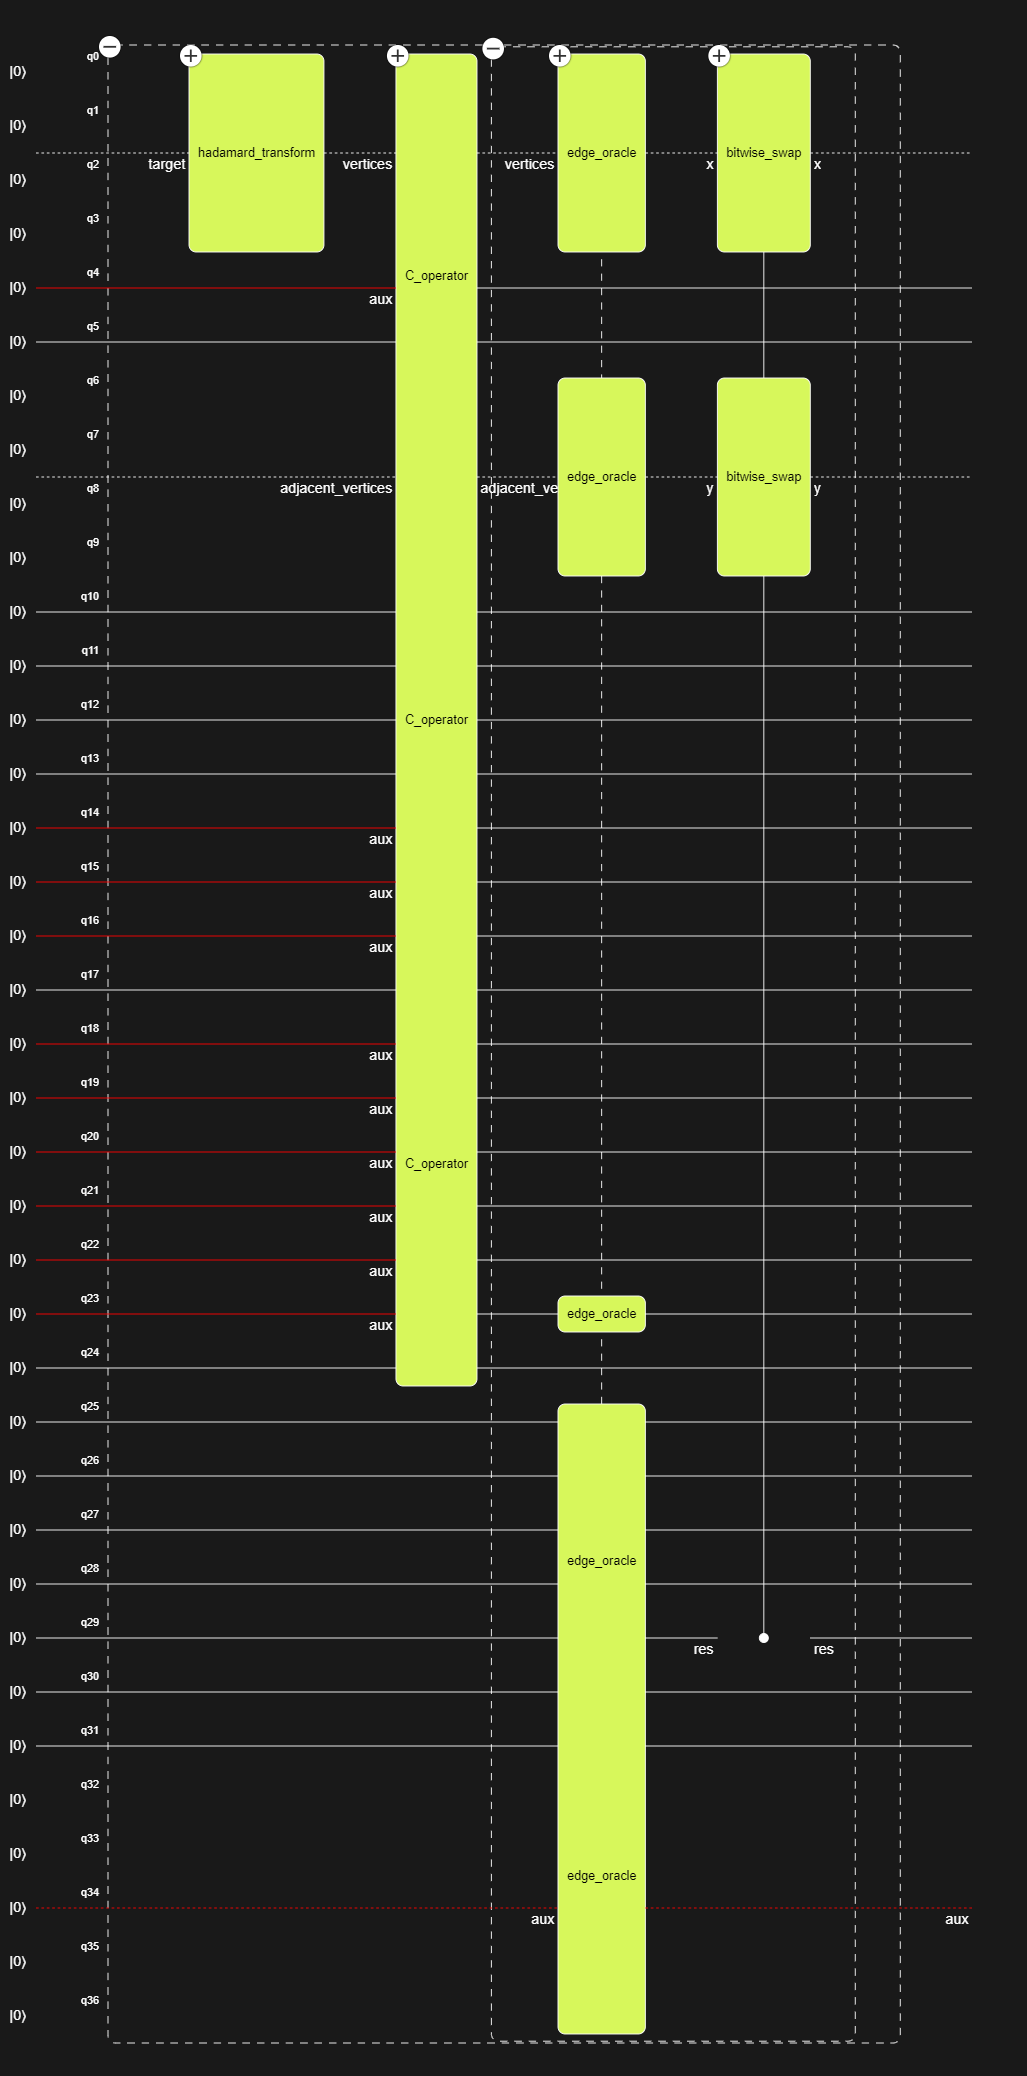
Fig. 3: Circuit Implementation of the S Operator

Shown in Fig. 3 is the circuit implementation of the S Operator consisting of:
* Edge oracle to determine whether nodes are adjacent (i.e. have an edge between them) and marks qubit, "res" as |1> if present
* Bitwise swap of adjacent node states, controlled by the "res" qubit

Hence, the S operator is implemented to perform the next step in the quantum walk.

# Conclusion

* In conclusion, this assignment provides a brief overview of the algorithm for discrete-time quantum random walks.
* This notebook also includes an implementation of the discrete-time quantum walk algorithm for a 16-node line graph using the Classiq Python SDK.
* Probability vectors were analyzed to validate the correctness of the implementation
* Circuit diagrams were described to verify and describe the high-level components of the algorithm as well as lower level implementation of their algorithmic building blocks
* The assignment was successfully implemented with the help of the modular and functional-oriented Classiq programming language, which enables higher levels of abstraction of quantum algorithms than gate-level quantum programming languages for quick and easy quantum algorithm implementation and development.